2011-2013 data for analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import glob
import os
import datetime
import pandas as pd
import netCDF4 as nc
import datetime
import pandas as pd
#import seaborn as sns tell me import error!!
from salishsea_tools.nowcast import figures
from salishsea_tools import viz_tools, nc_tools, tidetools
from glob import glob
%matplotlib inline

In [2]:
axis_font = {'fontname': 'Bitstream Vera Sans', 'size': '25'}
title_font = {
    'fontname': 'Bitstream Vera Sans', 'size': '30', 'color': 'black',
    'weight': 'medium'
}

In [3]:
import ACTDR

In [4]:
ACTDR.load_dat('SOG_new.dat')

> open  SOG_new.dat
> load CTD_DAT
> load STANDARD_KEYS
> close  SOG_new.dat
> complete


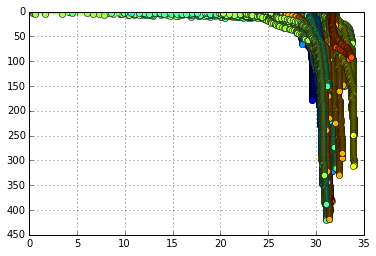

In [5]:
cmap=cm.get_cmap('jet',12)
count=0
for cast in ACTDR.CTD_DAT:
    plt.plot(cast['Salinity'],cast['Depth'],marker='o',c=cmap(cast['Month']-1))
    count=count+1
plt.axis([0,35,450,0])
plt.grid()

In [6]:
bathyy, X, Y = tidetools.get_SS2_bathy_data()

In [7]:
def select_cast_cSog(imin, imax, jmin, jmax):
    """This function was made to select 
        the cast in the different SoG region """
    
    s_cast = []
    for cast in ACTDR.CTD_DAT:
        [x1, y1] = tidetools.find_closest_model_point(cast['Longitude'] , \
        cast['Latitude'],X,Y,bathyy)
        if (x1 < jmax) & (x1 > jmin) & (y1 < imax) & (y1 > imin):
            s_cast.append(cast)
    return s_cast

# General statistical view of data in central Sog

In [8]:
## Select central SoG data
sog_data = select_cast_cSog(240, 350, 390, 450)

In [9]:
sog = pd.DataFrame(sog_data)

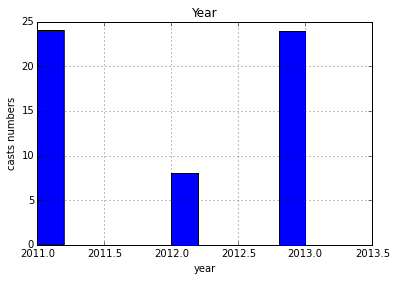

In [10]:
sog.hist('Year')
plt.ylabel('casts numbers')
plt.xlabel('year')
ax=plt.gca()
ax.get_xaxis().get_major_formatter().set_useOffset(False)

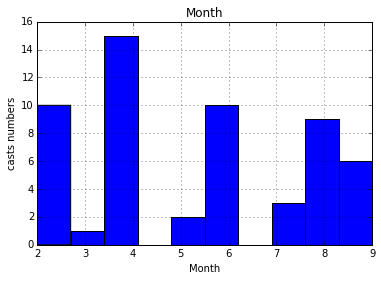

In [11]:
sog.hist('Month')
plt.ylabel('casts numbers')
plt.xlabel('Month')
ax=plt.gca()
ax.get_xaxis().get_major_formatter().set_useOffset(False)

* No data in central SoG region from 2011 to 2013 in Oct, Nov, Dec and Jan

In [12]:
def select_cast_month_more(imin, imax, jmin, jmax, Month):
    """This function was made to select 
        the cast in the SoG region in the
        specific month """
    
    s_cast = []
    for cast in ACTDR.CTD_DAT:
        [x1, y1] = tidetools.find_closest_model_point(cast['Longitude'] , \
        cast['Latitude'],X,Y,bathyy)
        if (x1 < jmax) & (x1 > jmin) & (y1 < imax) & (y1 > imin)  & (cast['Month'] == Month):
            s_cast.append(cast)
    return s_cast

In [13]:
def results_dataset(period, grid, results_dir):
    """Return the results dataset for period (e.g. 1h or 1d)
    and grid (e.g. grid_T, grid_U) from results_dir.
    """
    filename_pattern = 'SalishSea_{period}_*_{grid}.nc'
    filepaths = glob(os.path.join(results_dir, filename_pattern.format(period=period, grid=grid)))
    return nc.Dataset(filepaths[0])

In [14]:
def compare_cast_SoG_zoomin(imin,imax,jmin,jmax,Month,num):
    month = {'1':{'name': 'Jan'},'2':{'name': 'Feb'},\
    '3':{'name': 'Mar'}, '4':{'name': 'Apr'},'5':{'name': 'May'},\
    '6':{'name': 'Jun'},'7':{'name': 'Jul'},'8':{'name': 'Aug'},\
    '9':{'name': 'Sep'}, '10':{'name': 'Oct'}, '11':{'name': 'Nov'},\
    '12':{'name': 'Dec'}}
    results_home = '/data/dlatorne/MEOPAR/SalishSea/nowcast/'
    fig,axs=plt.subplots(1,4,figsize=(50,15))
    #map
    ax=axs[0]
    grid = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
    lons = grid.variables['nav_lon']
    lats = grid.variables['nav_lat']
    s_cast = select_cast_month_more(imin, imax, jmin, jmax,Month)
    for cast in s_cast:
        sites, =ax.plot(cast['Longitude'],cast['Latitude'],'DodgerBlue',marker='.', label = 'sites')
        ax.legend([sites],['sites'],loc = 1, fontsize = 25)

    viz_tools.plot_coastline(ax, grid, coords = 'map')
    ax.plot(lons[jmin, imin:imax,],lats[jmin, imin:imax],'r-')
    ax.plot(lons[jmax, imin:imax,],lats[jmax, imin:imax,],'r-')
    ax.plot(lons[ jmin:jmax, imin],lats[jmin:jmax, imin],'r-')
    ax.plot(lons[jmin:jmax, imax],lats[jmin:jmax, imax],'r-')    
    ax.set_xlim([-125.5,-122])
    ax.set_ylim([48.5,50.5])
    plt.setp(ax.get_xticklabels(), fontsize=25)
    plt.setp(ax.get_yticklabels(), fontsize=25)
    ax.set_xlabel('Longitude', **axis_font)
    ax.set_ylabel('Latitude', **axis_font)    
    count = 0
    ##prepare nowcasts results
    for cast in s_cast:
        if Month >= 10:
            run_date = datetime.datetime(2014, Month,cast['Day'])
        else:
            run_date = datetime.datetime(2015, Month,cast['Day'])
        # Results dataset location
        results_dir = os.path.join(results_home, run_date.strftime('%d%b%y').lower())
        grid_T_hr = results_dataset('1d', 'grid_T', results_dir)
        sal_hr = grid_T_hr.variables['vosaline']
        depth = grid_T_hr.variables['deptht']
        bathyy, X, Y = tidetools.get_SS2_bathy_data()
        [x1, y1] = tidetools.find_closest_model_point(cast['Longitude'] , \
        cast['Latitude'],X,Y,bathyy)
        sal_hr = np.ma.masked_values(sal_hr[0,:,x1,y1], 0)
        ax = axs[1]
        modd, = ax.plot(sal_hr, depth[:], 'MediumBlue',marker = '*')
        ##profile comparison          
        obss, =ax.plot(cast['Salinity'],cast['Depth'],'DarkGreen',marker='o')
        count=count+1
        ax.axis([0,35,400,0])
        ax.grid('on')   
        ax.set_title('Comparison in '+ str(month[num]['name']), **title_font)
        plt.setp(ax.get_xticklabels(), fontsize=25)
        plt.setp(ax.get_yticklabels(), fontsize=25)
        ax.set_xlabel('salinity', **axis_font)
        ax.set_ylabel('depth [m]', **axis_font)
        ax.legend([modd,obss],['mod','obs'],loc = 2, fontsize = 25)
        ax = axs[2]
        mod, = ax.plot(sal_hr, depth[:], 'MediumBlue',marker = '*')
        obs, = ax.plot(cast['Salinity'],cast['Depth'],'DarkGreen', marker='o')
        ax.set_xlim(0, 35)
        ax.set_ylim(80, 0)
        ax.set_title('Zoom in top 80m ',**title_font)
        plt.setp(ax.get_xticklabels(), fontsize=25)
        plt.setp(ax.get_yticklabels(), fontsize=25)
        ax.set_xlabel('salinity', **axis_font)
        ax.set_ylabel('depth [m]', **axis_font)
        ax.grid('on') 
        ax.legend([mod,obs],['mod','obs'],loc = 2, fontsize = 25)
        ax = axs[3]
        mod, = ax.plot(sal_hr, depth[:], 'MediumBlue',marker = '*')
        obs, = ax.plot(cast['Salinity'],cast['Depth'],'DarkGreen', marker='o')
        ax.set_xlim(0, 35)
        ax.set_ylim(20, 0)
        ax.set_title('Zoom in top 20m ',**title_font)
        plt.setp(ax.get_xticklabels(), fontsize=25)
        plt.setp(ax.get_yticklabels(), fontsize=25)
        ax.set_xlabel('salinity', **axis_font)
        ax.set_ylabel('depth [m]', **axis_font)
        ax.grid('on') 
        ax.legend([mod,obs],['mod','obs'],loc = 2, fontsize = 25)
              
    return fig

In [15]:
def compare_cast_SoG_zoomin_more(sog,Month, imin,imax,jmin,jmax,num):
    """This function was made to compare climatology observed data
        with model results, zoom in top 20 m ultimately, with max, min
        mean of observed & modelled surface salinity displaying"""
    
    month = {'1':{'name': 'Jan'},'2':{'name': 'Feb'},\
    '3':{'name': 'Mar'}, '4':{'name': 'Apr'},'5':{'name': 'May'},\
    '6':{'name': 'Jun'},'7':{'name': 'Jul'},'8':{'name': 'Aug'},\
    '9':{'name': 'Sep'}, '10':{'name': 'Oct'}, '11':{'name': 'Nov'},\
    '12':{'name': 'Dec'}}
    max_obs_surface = []
    min_obs_surface = []
    max_mod_surface = []
    min_mod_surface = []
    sog_month = sog[sog['Month']== Month]
    dep = sog_month['Depth']
    sal = sog_month['Salinity']
    if max(dep)[0] <5: 
        max_obs_surface.append(max(sal)[0])
        min_obs_surface.append(min(sal)[0])
    results_home = '/data/dlatorne/MEOPAR/SalishSea/nowcast/'
    fig,axs=plt.subplots(1,4,figsize=(60,20))
    #map
    ax=axs[0]
    grid = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
    lons = grid.variables['nav_lon']
    lats = grid.variables['nav_lat']
    s_cast = select_cast_month_more(imin, imax, jmin, jmax,Month)
    for cast in s_cast:
        if Month != 3:
            sites, =ax.plot(cast['Longitude'],cast['Latitude'],'DodgerBlue',marker='*',\
            markersize=20, label = 'sites')
            ax.legend([sites],['sites'],loc = 1, fontsize = 25)
        elif Month ==3:
            ax.plot(cast['Longitude'],cast['Latitude'],'DodgerBlue',marker='*', \
                    markersize=20, label = 'sites')
    viz_tools.plot_coastline(ax, grid, coords = 'map')
    ax.plot(lons[jmin, imin:imax,],lats[jmin, imin:imax],'r-')
    ax.plot(lons[jmax, imin:imax,],lats[jmax, imin:imax,],'r-')
    ax.plot(lons[jmin:jmax, imin],lats[jmin:jmax, imin],'r-')
    ax.plot(lons[jmin:jmax, imax],lats[jmin:jmax, imax],'r-')    
    ax.set_xlim([-124.,-122.8])
    ax.set_ylim([48.6,49.3])
    ax.set_xlabel('Longitude', **axis_font)
    ax.set_ylabel('Latitude', **axis_font)
    plt.setp(ax.get_xticklabels(), fontsize=25)
    plt.setp(ax.get_yticklabels(), fontsize=25)
    count = 0
    ##prepare nowcasts results
    for cast in s_cast:
        if Month >= 10:
            run_date = datetime.datetime(2014, Month,cast['Day'])
        else:
            run_date = datetime.datetime(2015, Month,cast['Day'])
        # Results dataset location
        results_dir = os.path.join(results_home, run_date.strftime('%d%b%y').lower())
        grid_T_hr = results_dataset('1d', 'grid_T', results_dir)
        sal_hr = grid_T_hr.variables['vosaline']
        depth = grid_T_hr.variables['deptht']
        bathyy, X, Y = tidetools.get_SS2_bathy_data()
        [x1, y1] = tidetools.find_closest_model_point(cast['Longitude'] , \
        cast['Latitude'],X,Y,bathyy)
        sal_hr = np.ma.masked_values(sal_hr[0,:,x1,y1], 0)
        max_mod_surface.append(np.nanmax(sal_hr[0:4]))
        min_mod_surface.append(np.nanmin(sal_hr[0:4]))
        ax = axs[1]
        modd, = ax.plot(sal_hr, depth[:], 'MediumBlue',marker = '*',\
                       markersize = 8, linewidth=5.0)
        ##profile comparison          
        obss, =ax.plot(cast['Salinity'],cast['Depth'],'DarkGreen',marker='o',\
        markersize = 8, linewidth=5.0)
        count=count+1
        ax.axis([0,35,400,0])
        ax.grid('on')   
        ax.set_title('Comparison in '+ str(month[num]['name']), **title_font)
        plt.setp(ax.get_xticklabels(), fontsize=25)
        plt.setp(ax.get_yticklabels(), fontsize=25)
        ax.set_xlabel('salinity', **axis_font)
        ax.set_ylabel('depth [m]', **axis_font)
        ax.legend([modd,obss],['mod','obs'],loc = 2, fontsize = 25)
        ax = axs[2]
        mod, = ax.plot(sal_hr, depth[:], 'MediumBlue',marker = '*',markersize = 8, linewidth=5.0)
        obs, = ax.plot(cast['Salinity'],cast['Depth'],'DarkGreen', marker='o',\
                      markersize = 8, linewidth=5.0)
        ax.set_xlim(0, 35)
        ax.set_ylim(80, 0)
        ax.set_title('Zoom in top 80m ',**title_font)
        plt.setp(ax.get_xticklabels(), fontsize=25)
        plt.setp(ax.get_yticklabels(), fontsize=25)
        ax.set_xlabel('salinity', **axis_font)
        ax.set_ylabel('depth [m]', **axis_font)
        ax.grid('on') 
        ax.legend([mod,obs],['mod','obs'],loc = 2, fontsize = 25)
        ax = axs[3]
        mod, = ax.plot(sal_hr, depth[:], 'MediumBlue',marker = '*',\
                      markersize = 8, linewidth=5.0)
        obs, = ax.plot(cast['Salinity'],cast['Depth'],'DarkGreen', marker='o',\
                      markersize = 8, linewidth=5.0)
        ax.set_xlim(0, 35)
        ax.set_ylim(20, 0)
        ax.set_title('Zoom in top 20m ',**title_font)
        plt.setp(ax.get_xticklabels(), fontsize=25)
        plt.setp(ax.get_yticklabels(), fontsize=25)
        ax.set_xlabel('salinity', **axis_font)
        ax.set_ylabel('depth [m]', **axis_font)
        ax.grid('on') 
        ax.legend([mod,obs],['mod','obs'],loc = 2, fontsize = 25)
    max_mod_max = np.nanmax(max_mod_surface)
    min_mod_min = np.nanmin(min_mod_surface)
    #axs[2].text( 0, 18,'Obs mean of surface {0:.4}'.format(max_obs_surface[0]),\
           #fontsize=35)
    #axs[2].text( 0, 18.5,'Mod mean of surface {0:.4}'.format(min_obs_surface[0]),\
           #fontsize=35)
    axs[3].text( 0, 18,'Obs max of surface {0:.4}'.format(max_obs_surface[0]),\
           fontsize=35)
    axs[3].text( 0, 18.5,'Obs min of surface {0:.4}'.format(min_obs_surface[0]),\
           fontsize=35)
    axs[3].text( 0, 19,'Mod max of surface {0:.4}'.format(max_mod_max),\
           fontsize=35)
    axs[3].text( 0, 19.5,'Mod min of surface {0:.4}'.format(min_mod_min),\
           fontsize=35)
                
    return fig

In [16]:
s_cast = select_cast_month_more(240, 350, 390, 450,10)

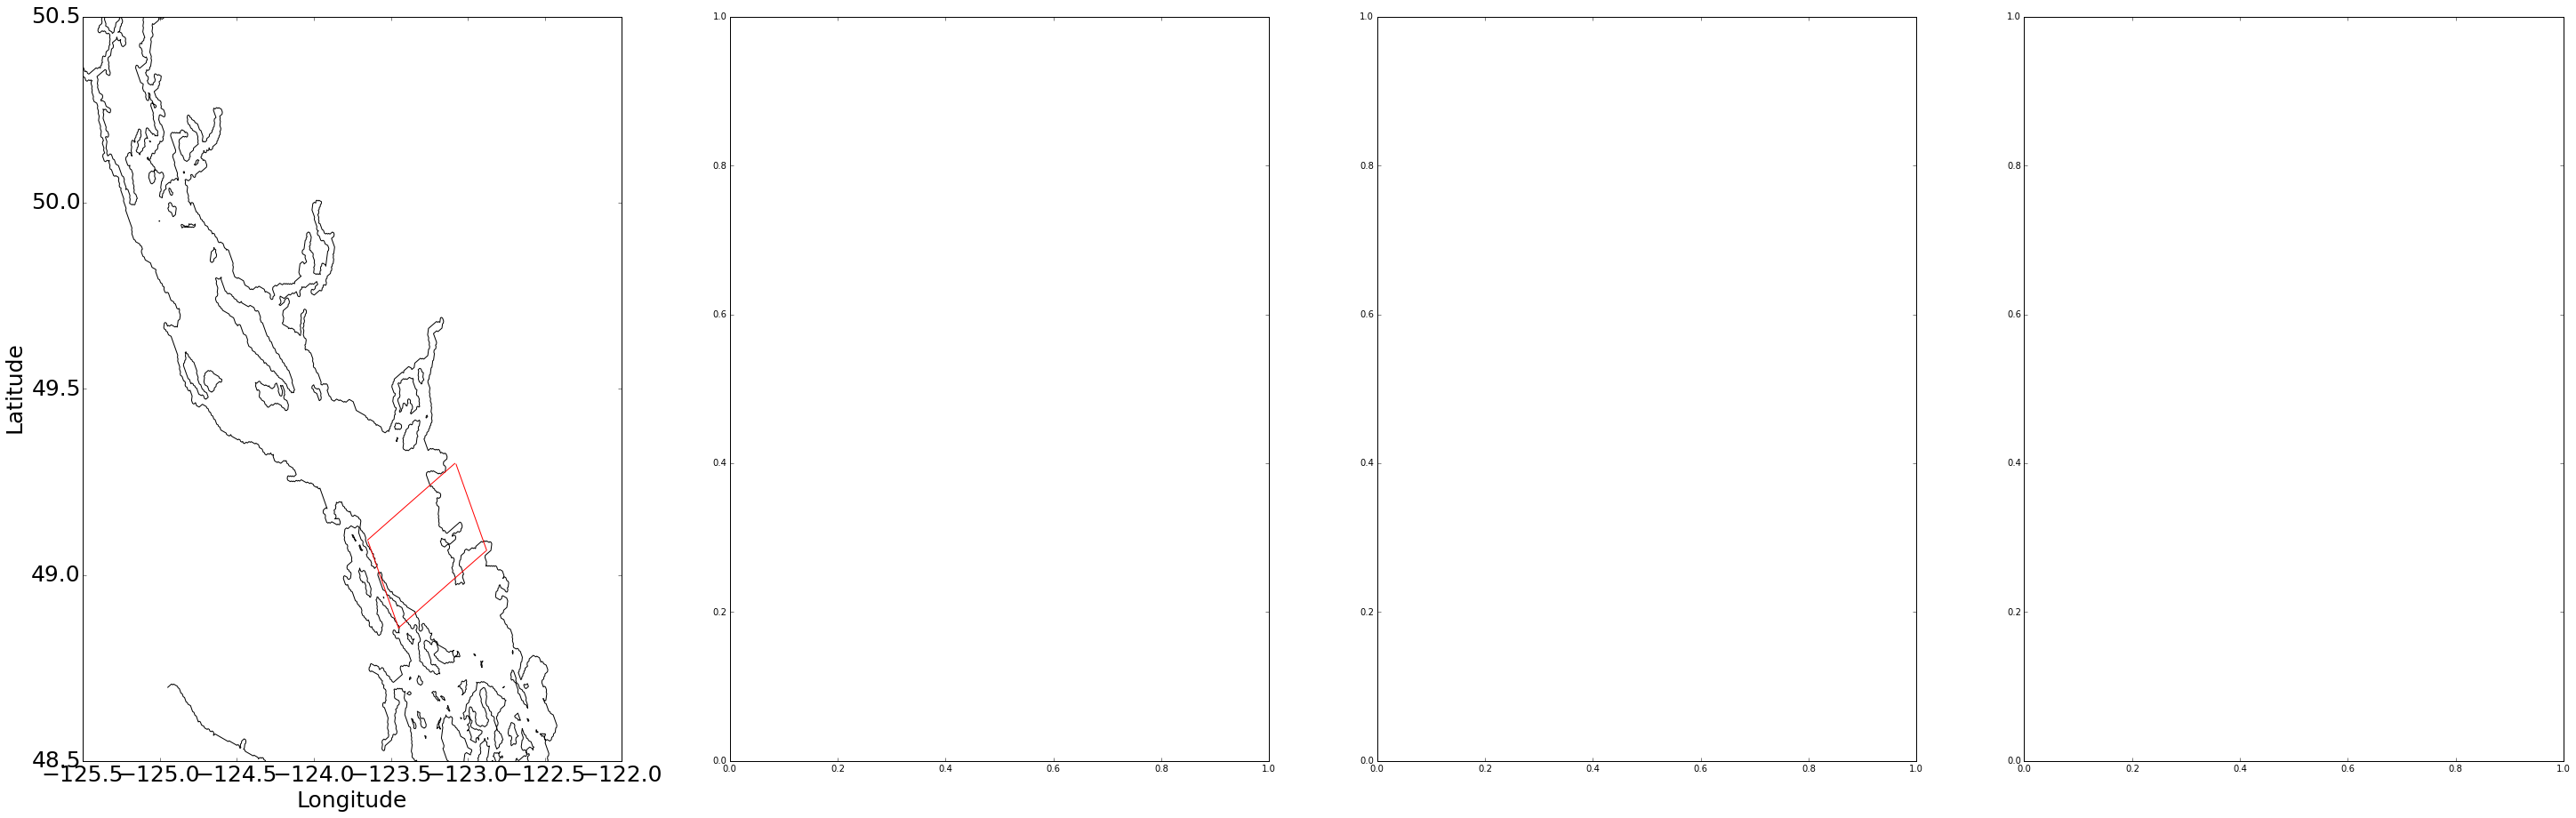

In [17]:
## Oct
fig = compare_cast_SoG_zoomin(240, 350, 390, 450, 10, '10')

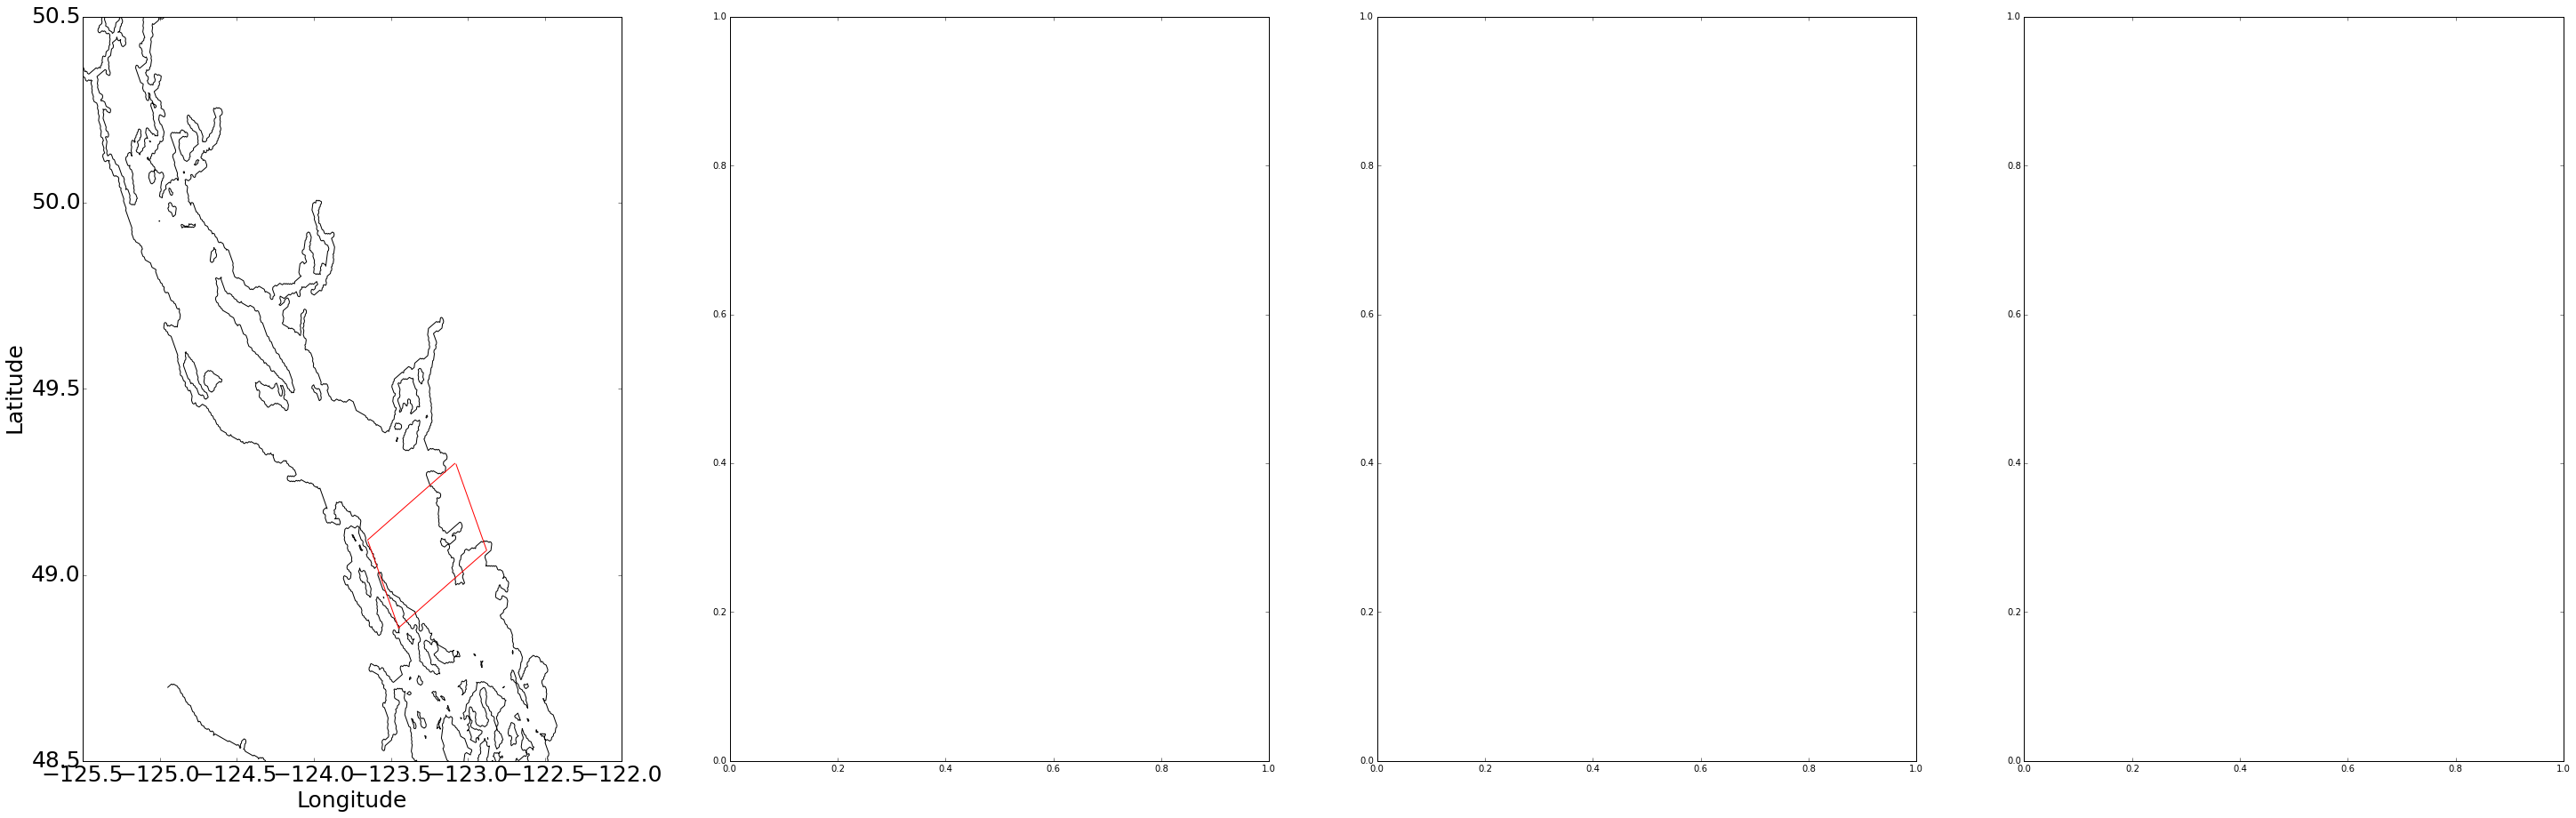

In [18]:
## Nov
fig = compare_cast_SoG_zoomin(240, 350, 390, 450, 11, '11')

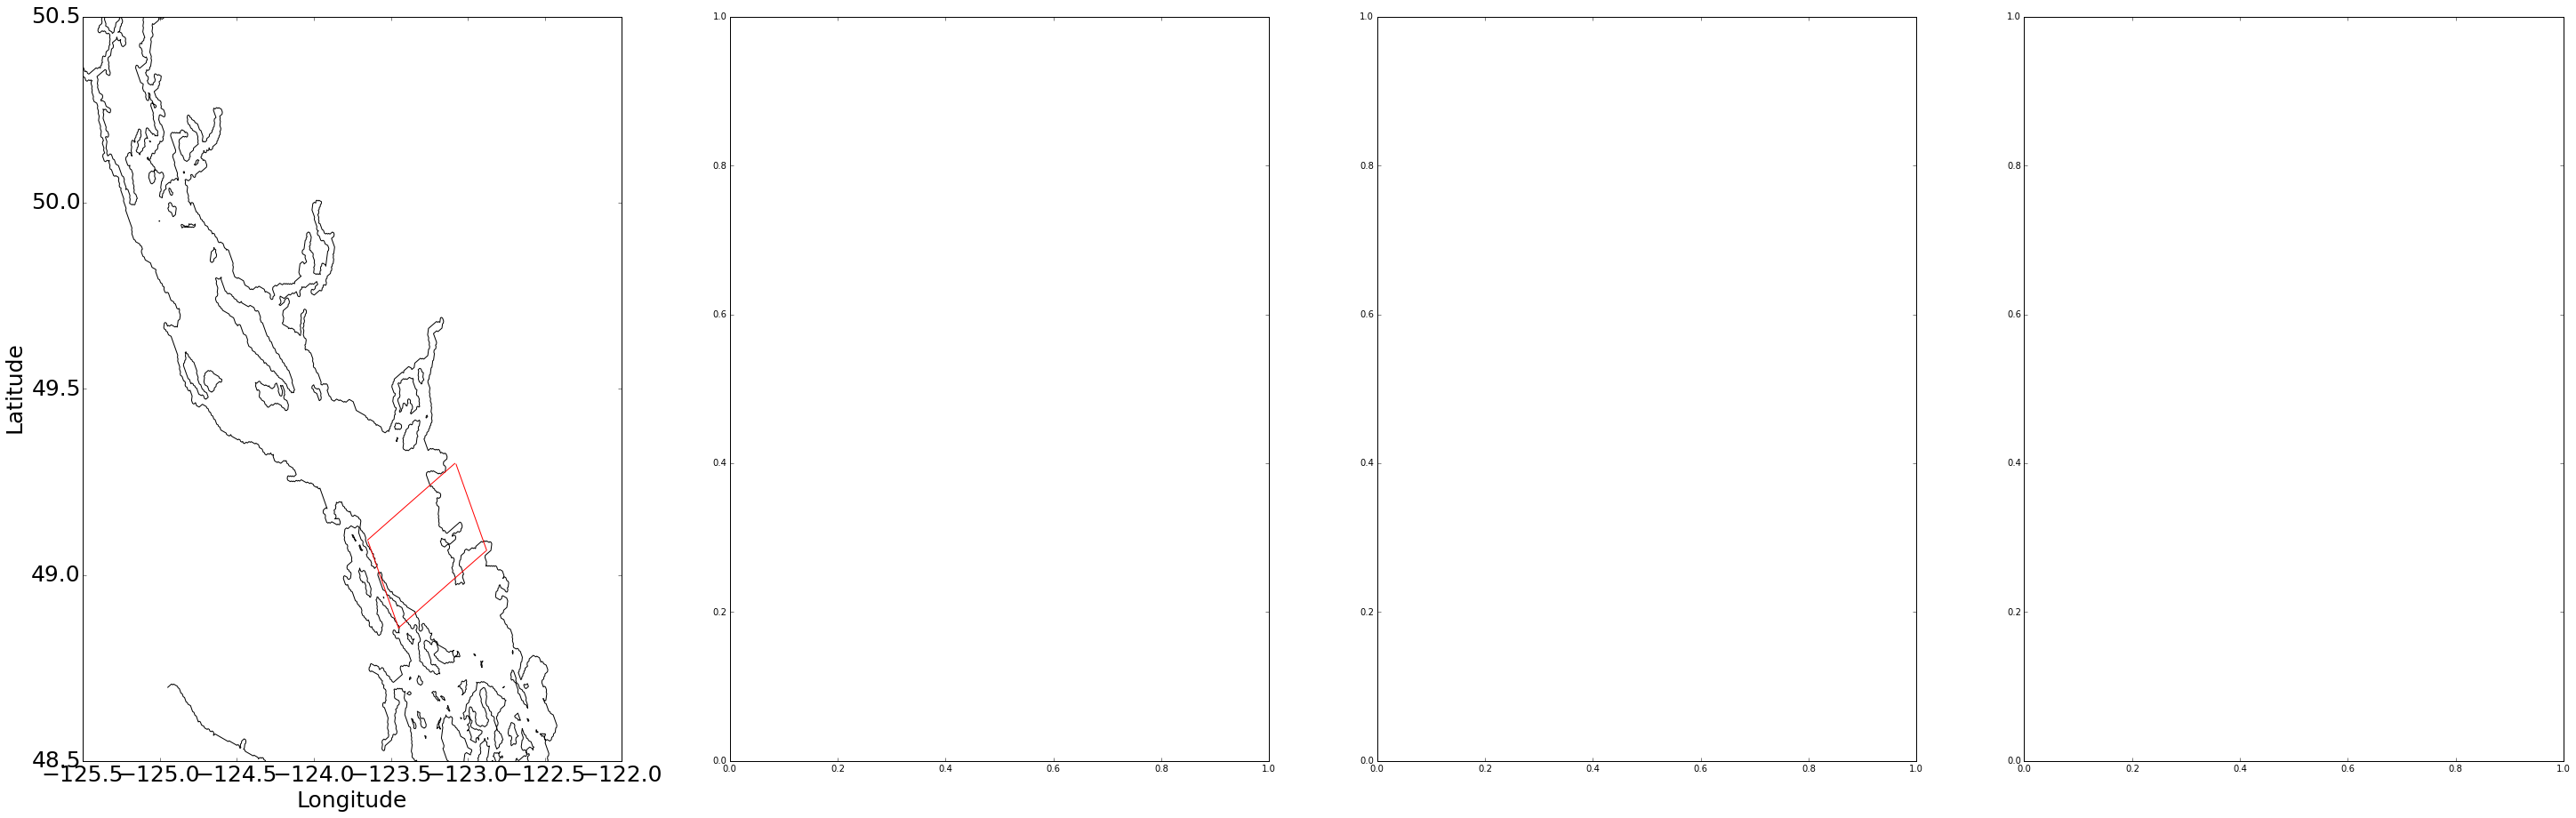

In [19]:
## Dec
fig = compare_cast_SoG_zoomin(240, 350, 390, 450, 12,'12')

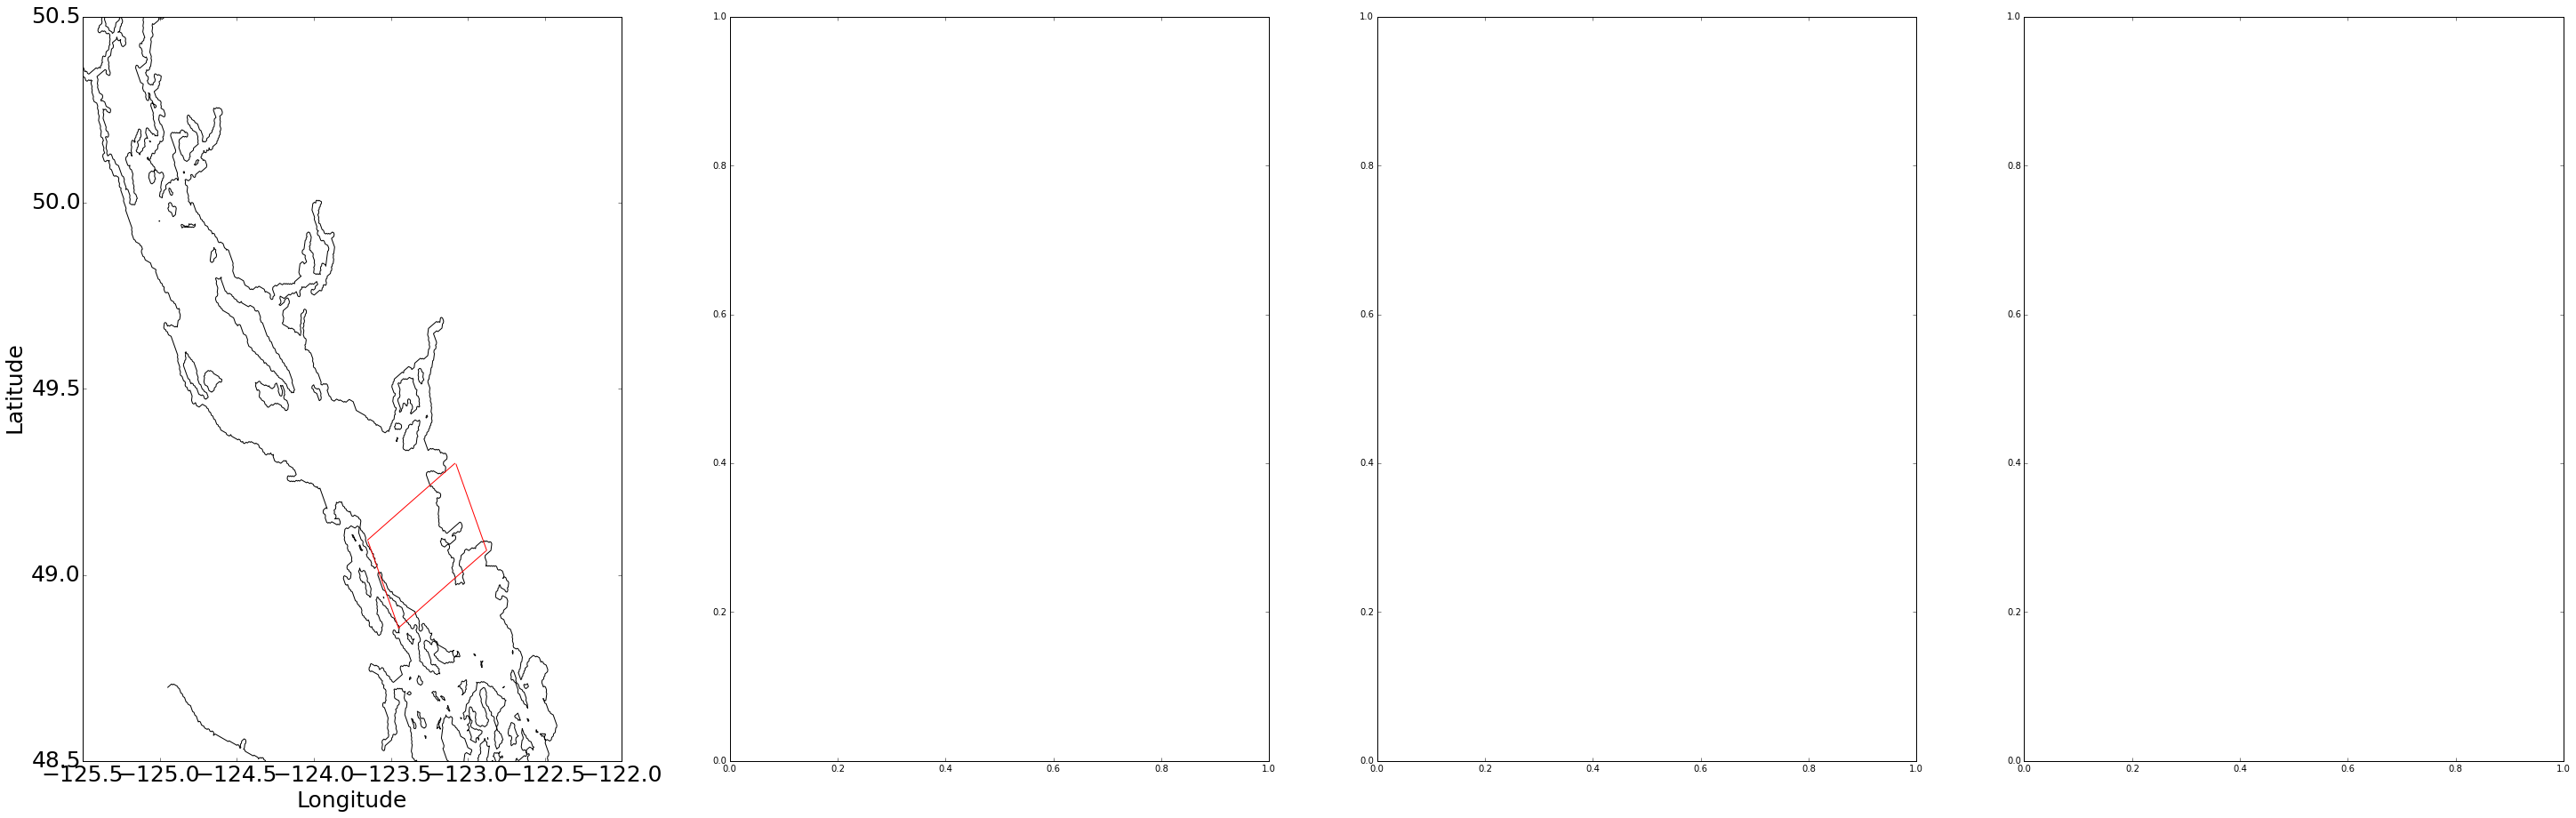

In [20]:
## Jan
fig = compare_cast_SoG_zoomin(240, 350, 390, 450, 1, '1')

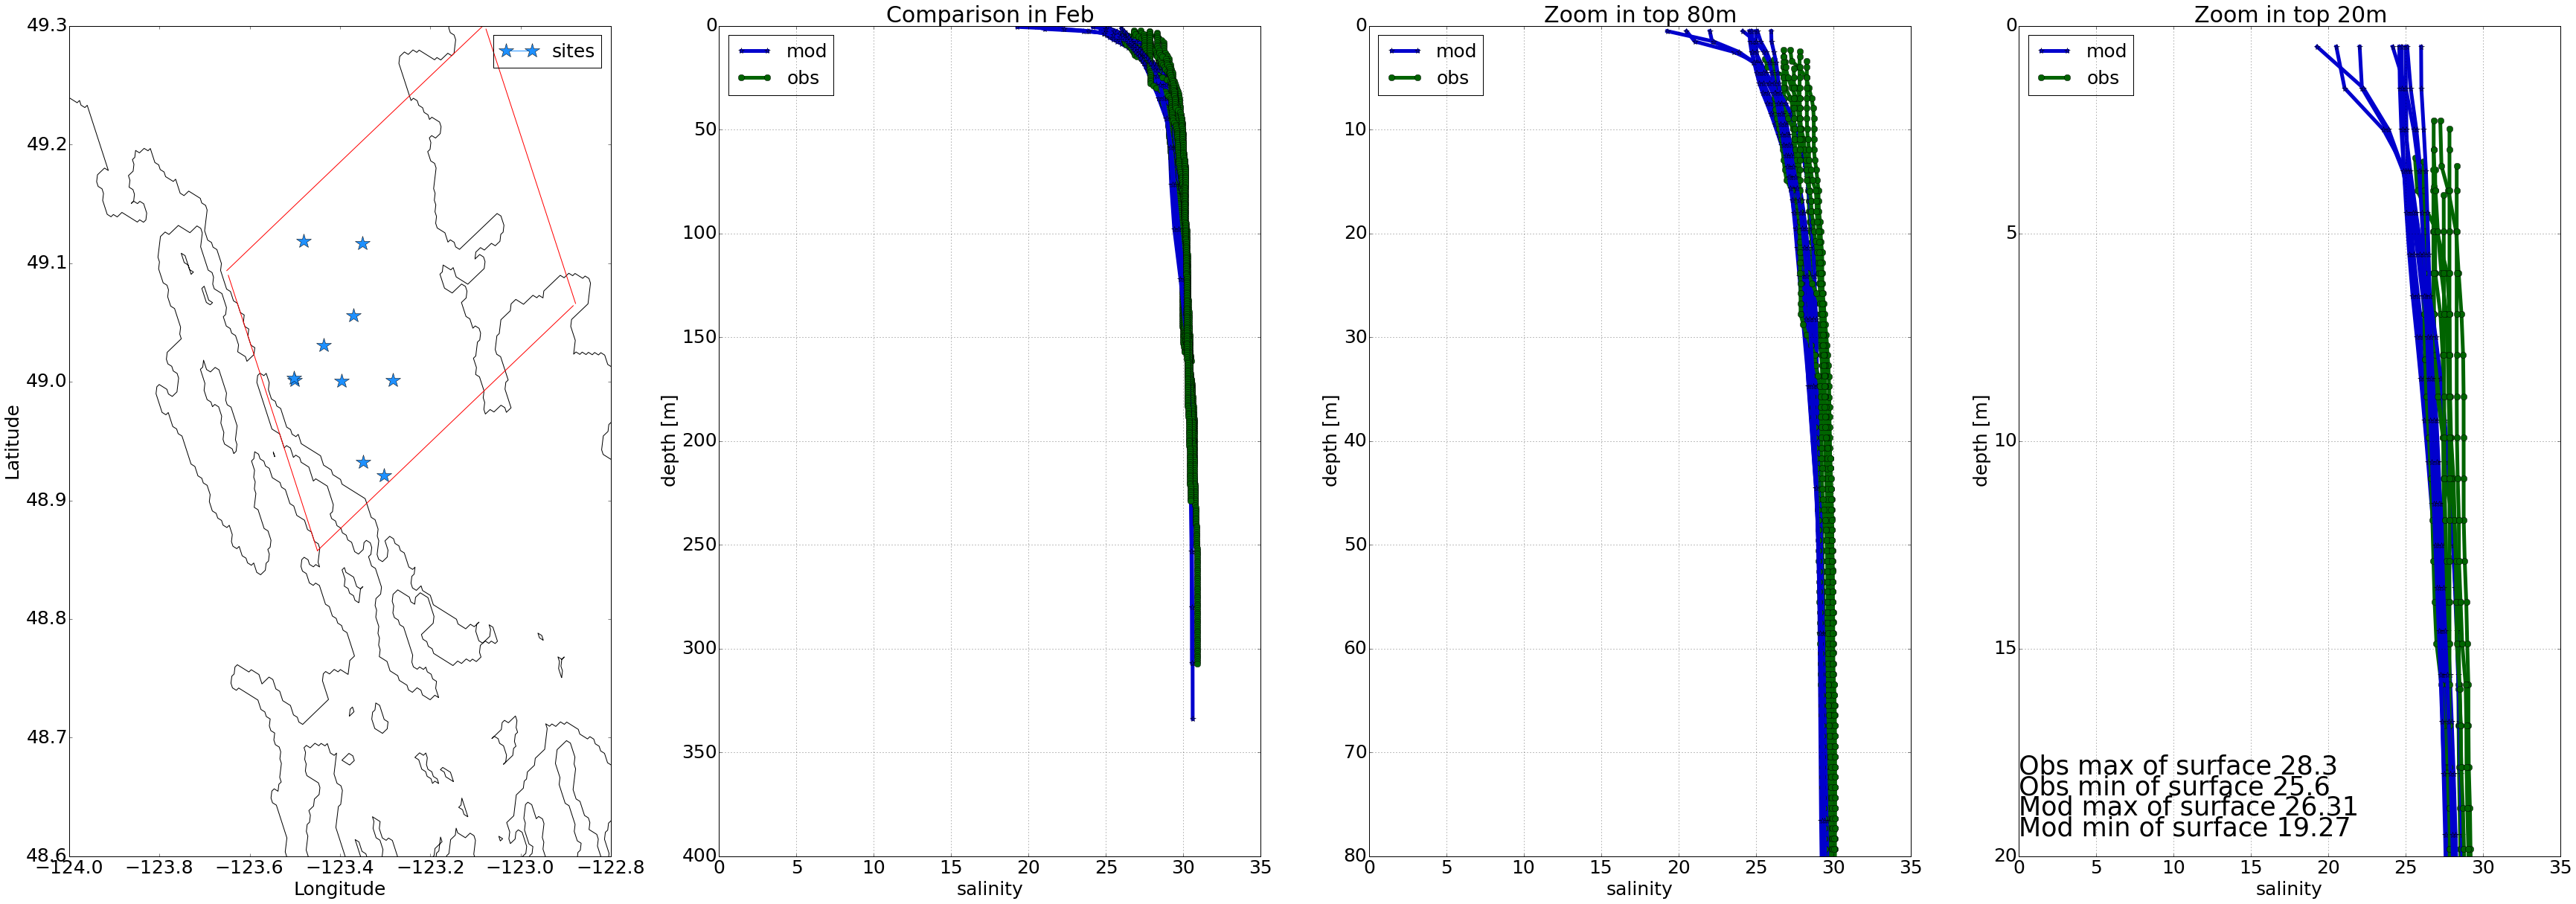

In [21]:
## Feb
fig = compare_cast_SoG_zoomin_more(sog,2,240, 350, 390, 450, '2')

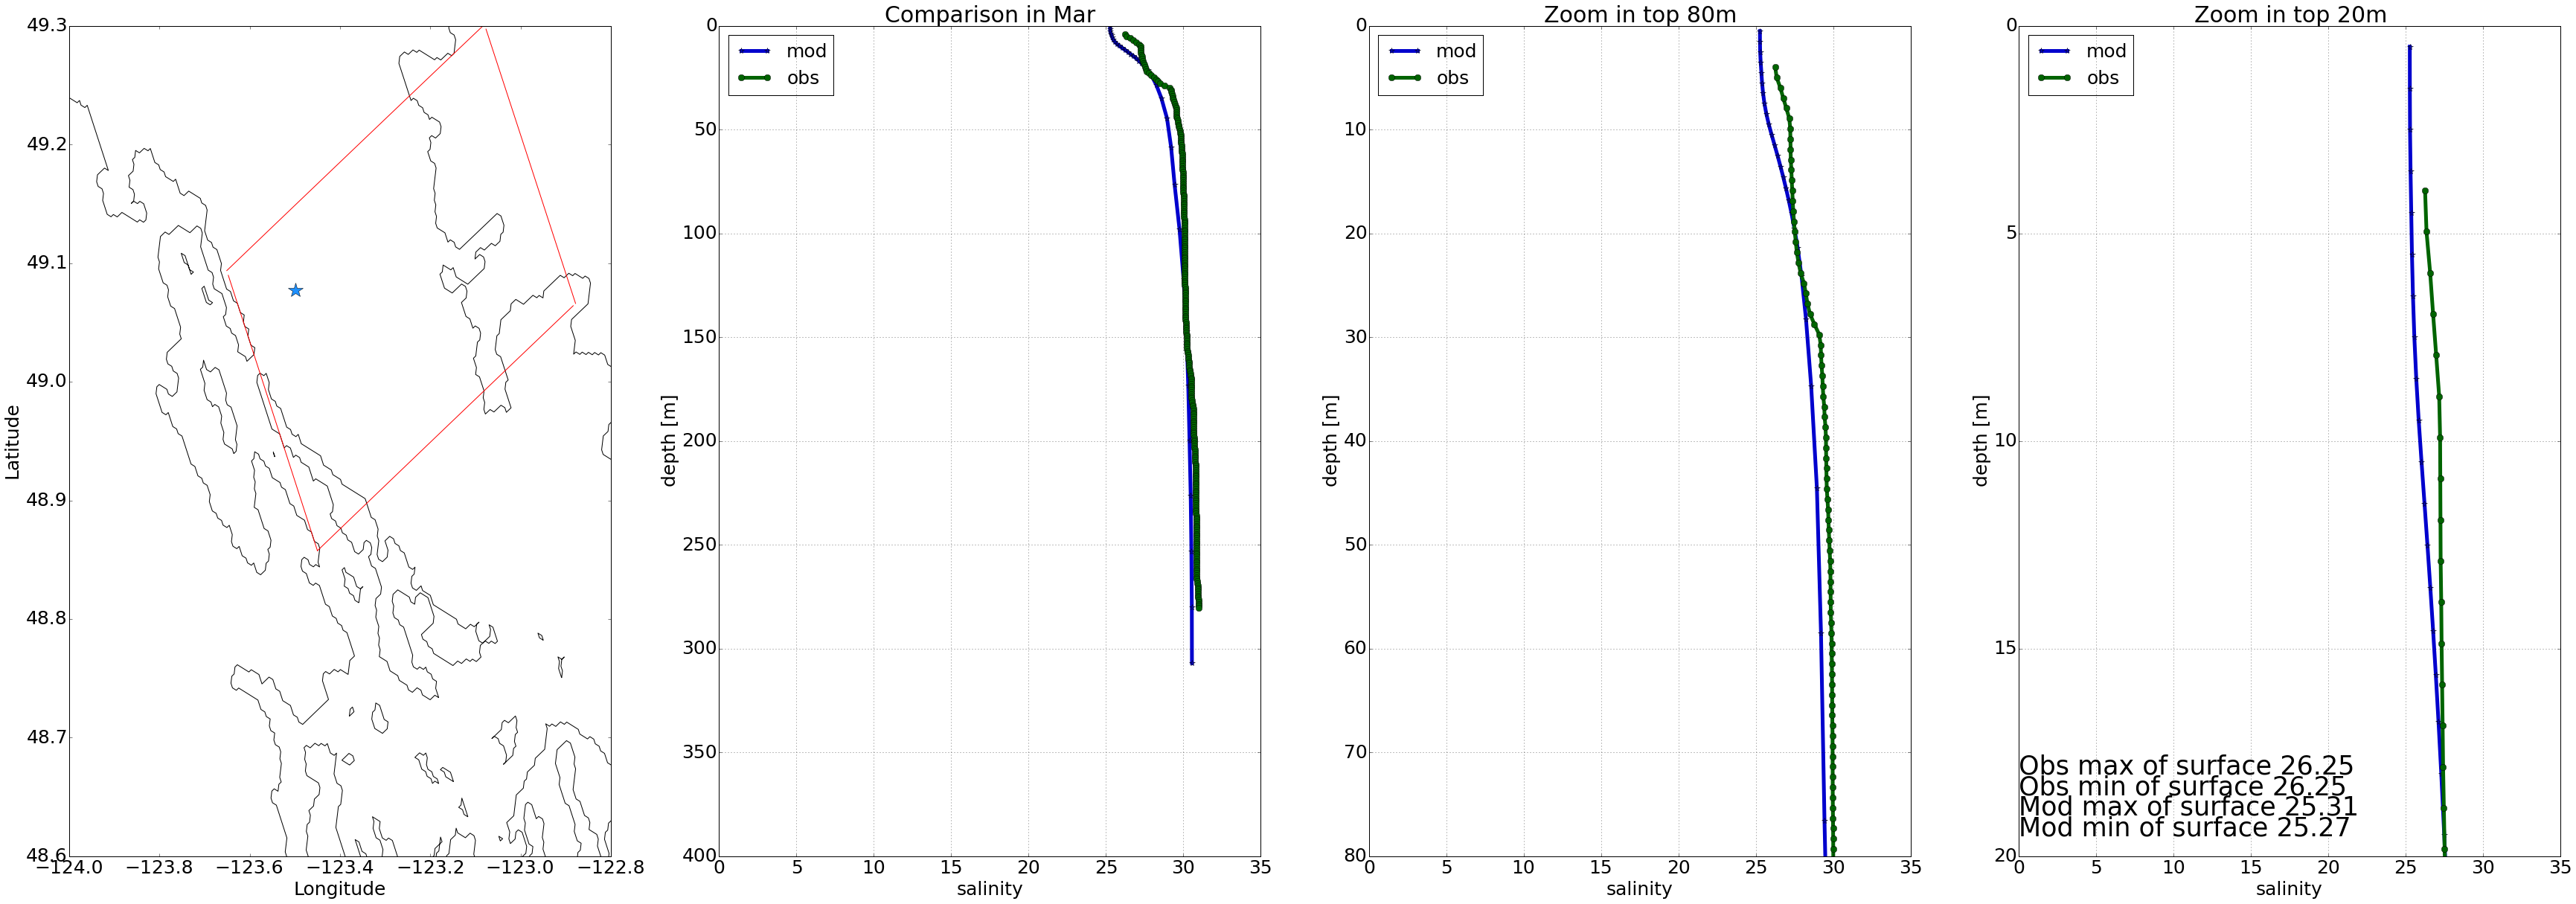

In [22]:
##March
fig = compare_cast_SoG_zoomin_more(sog,3,240, 350, 390, 450, '3')

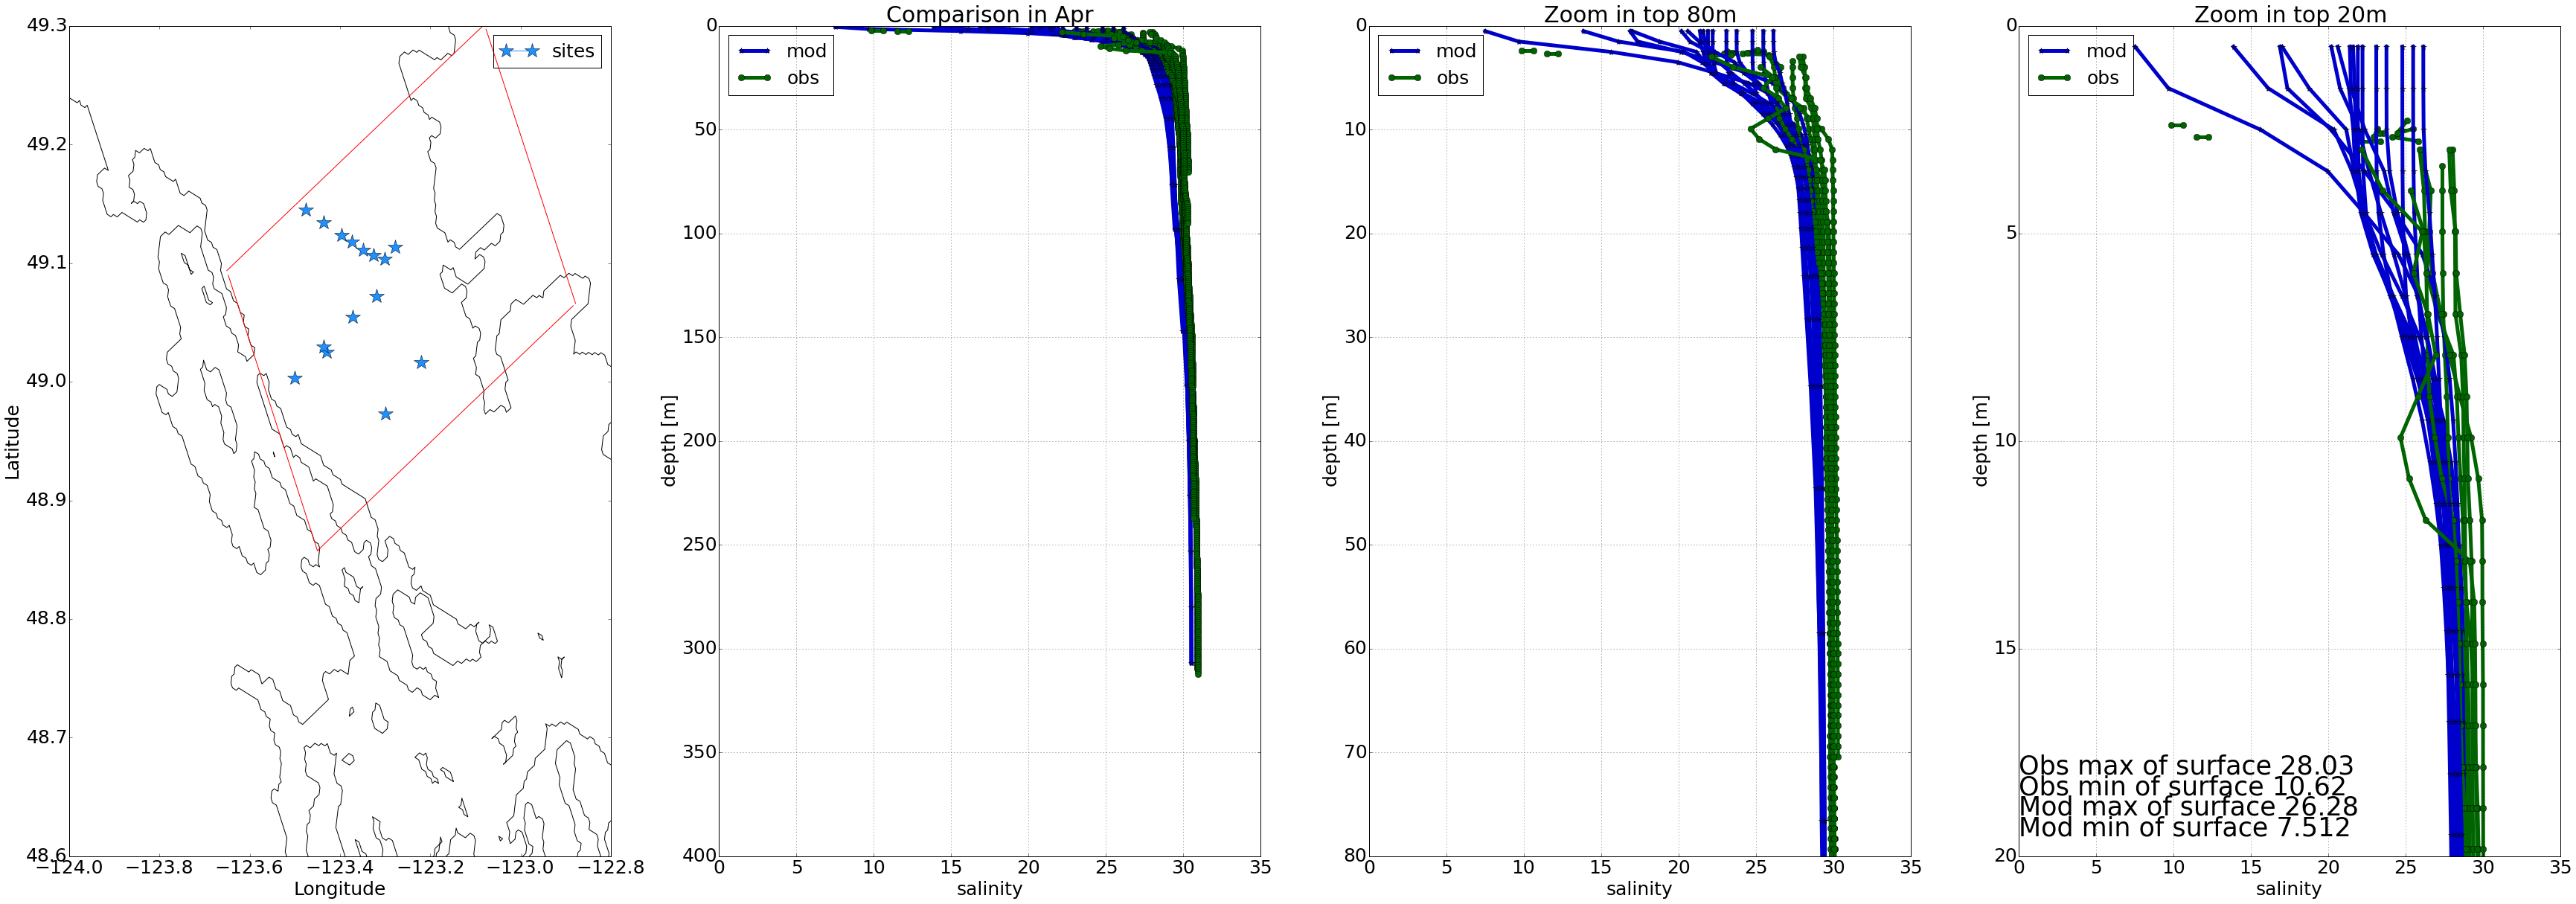

In [23]:
##April
fig = compare_cast_SoG_zoomin_more(sog,4,240, 350, 390, 450,'4')

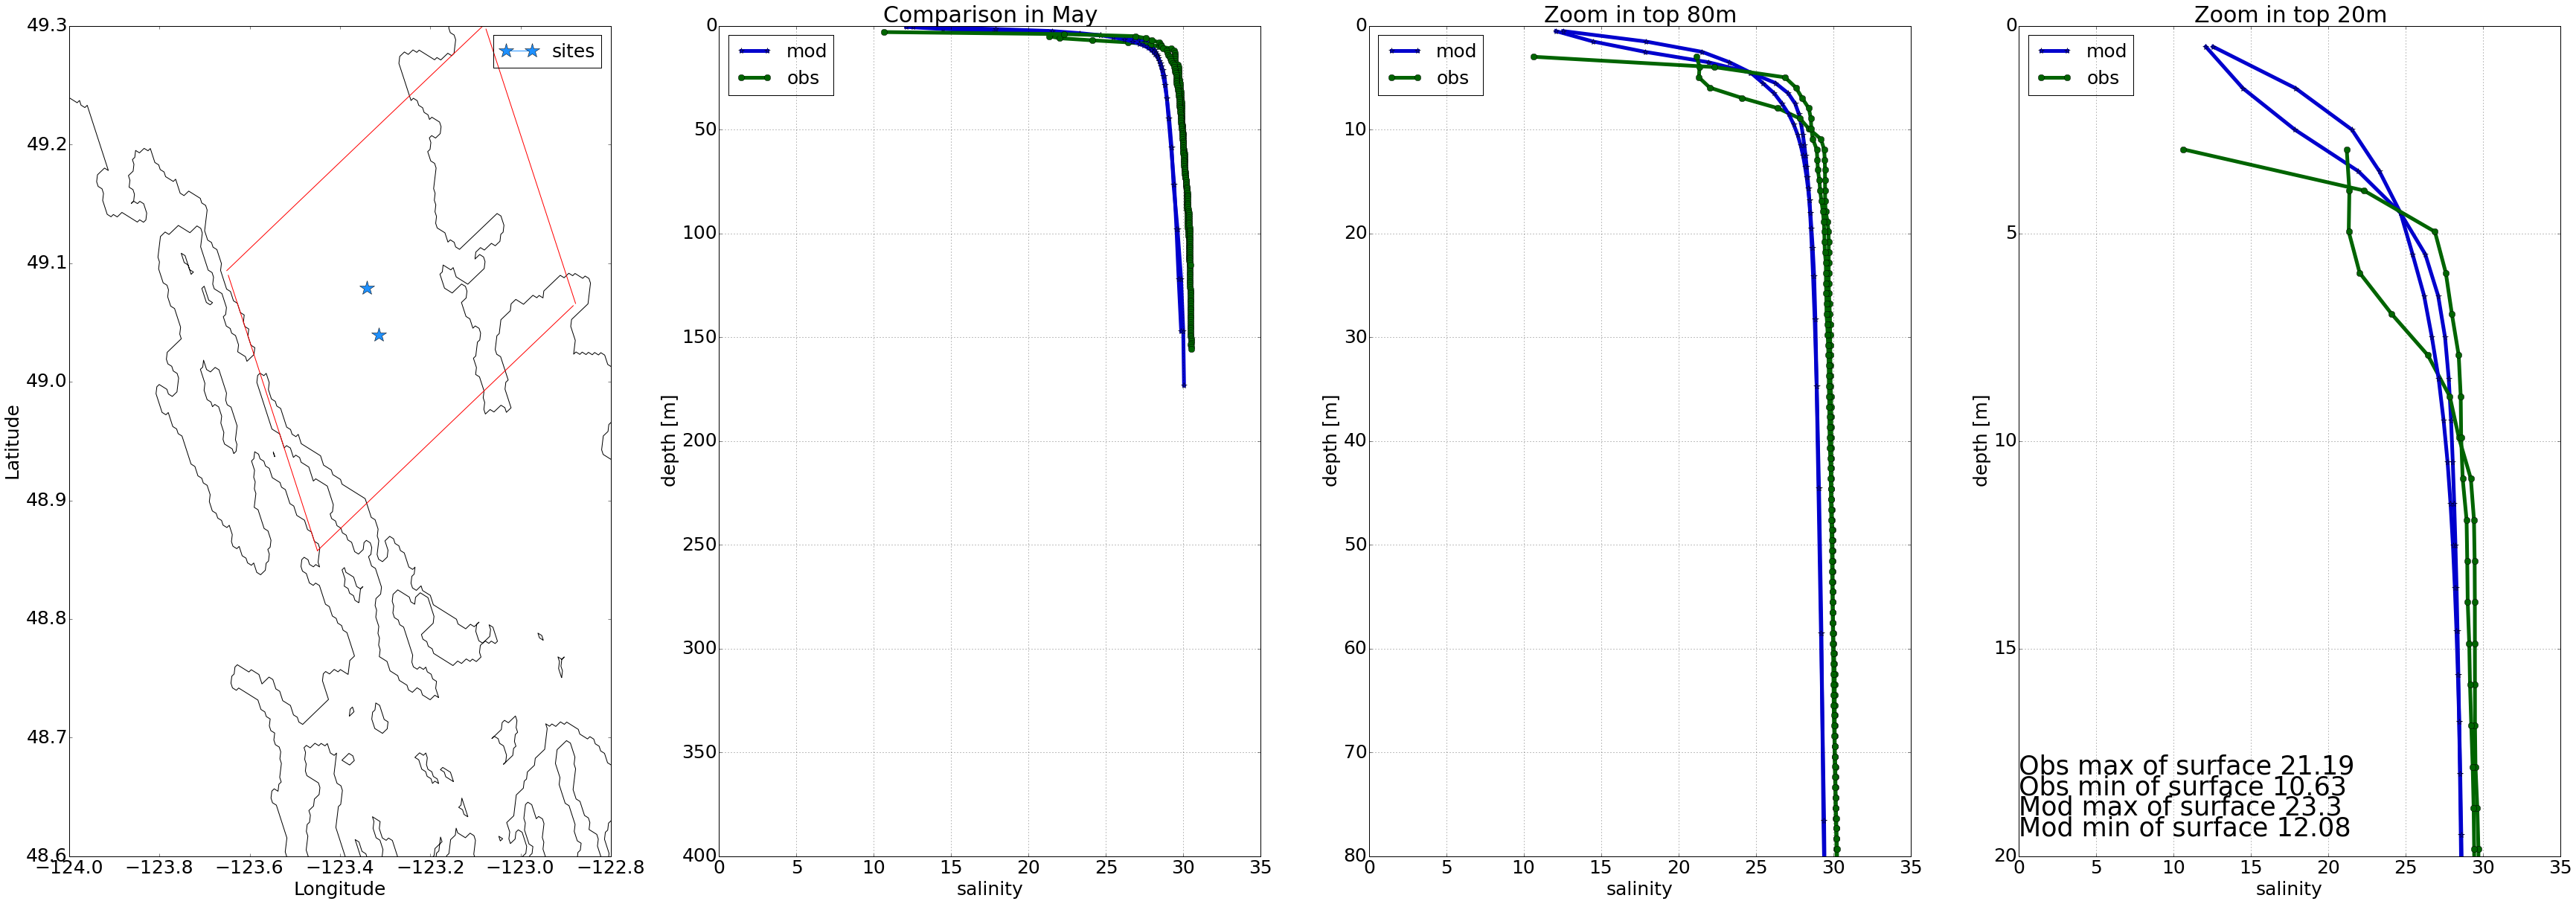

In [24]:
## May
fig = compare_cast_SoG_zoomin_more(sog, 5, 240, 350, 390, 450, '5')

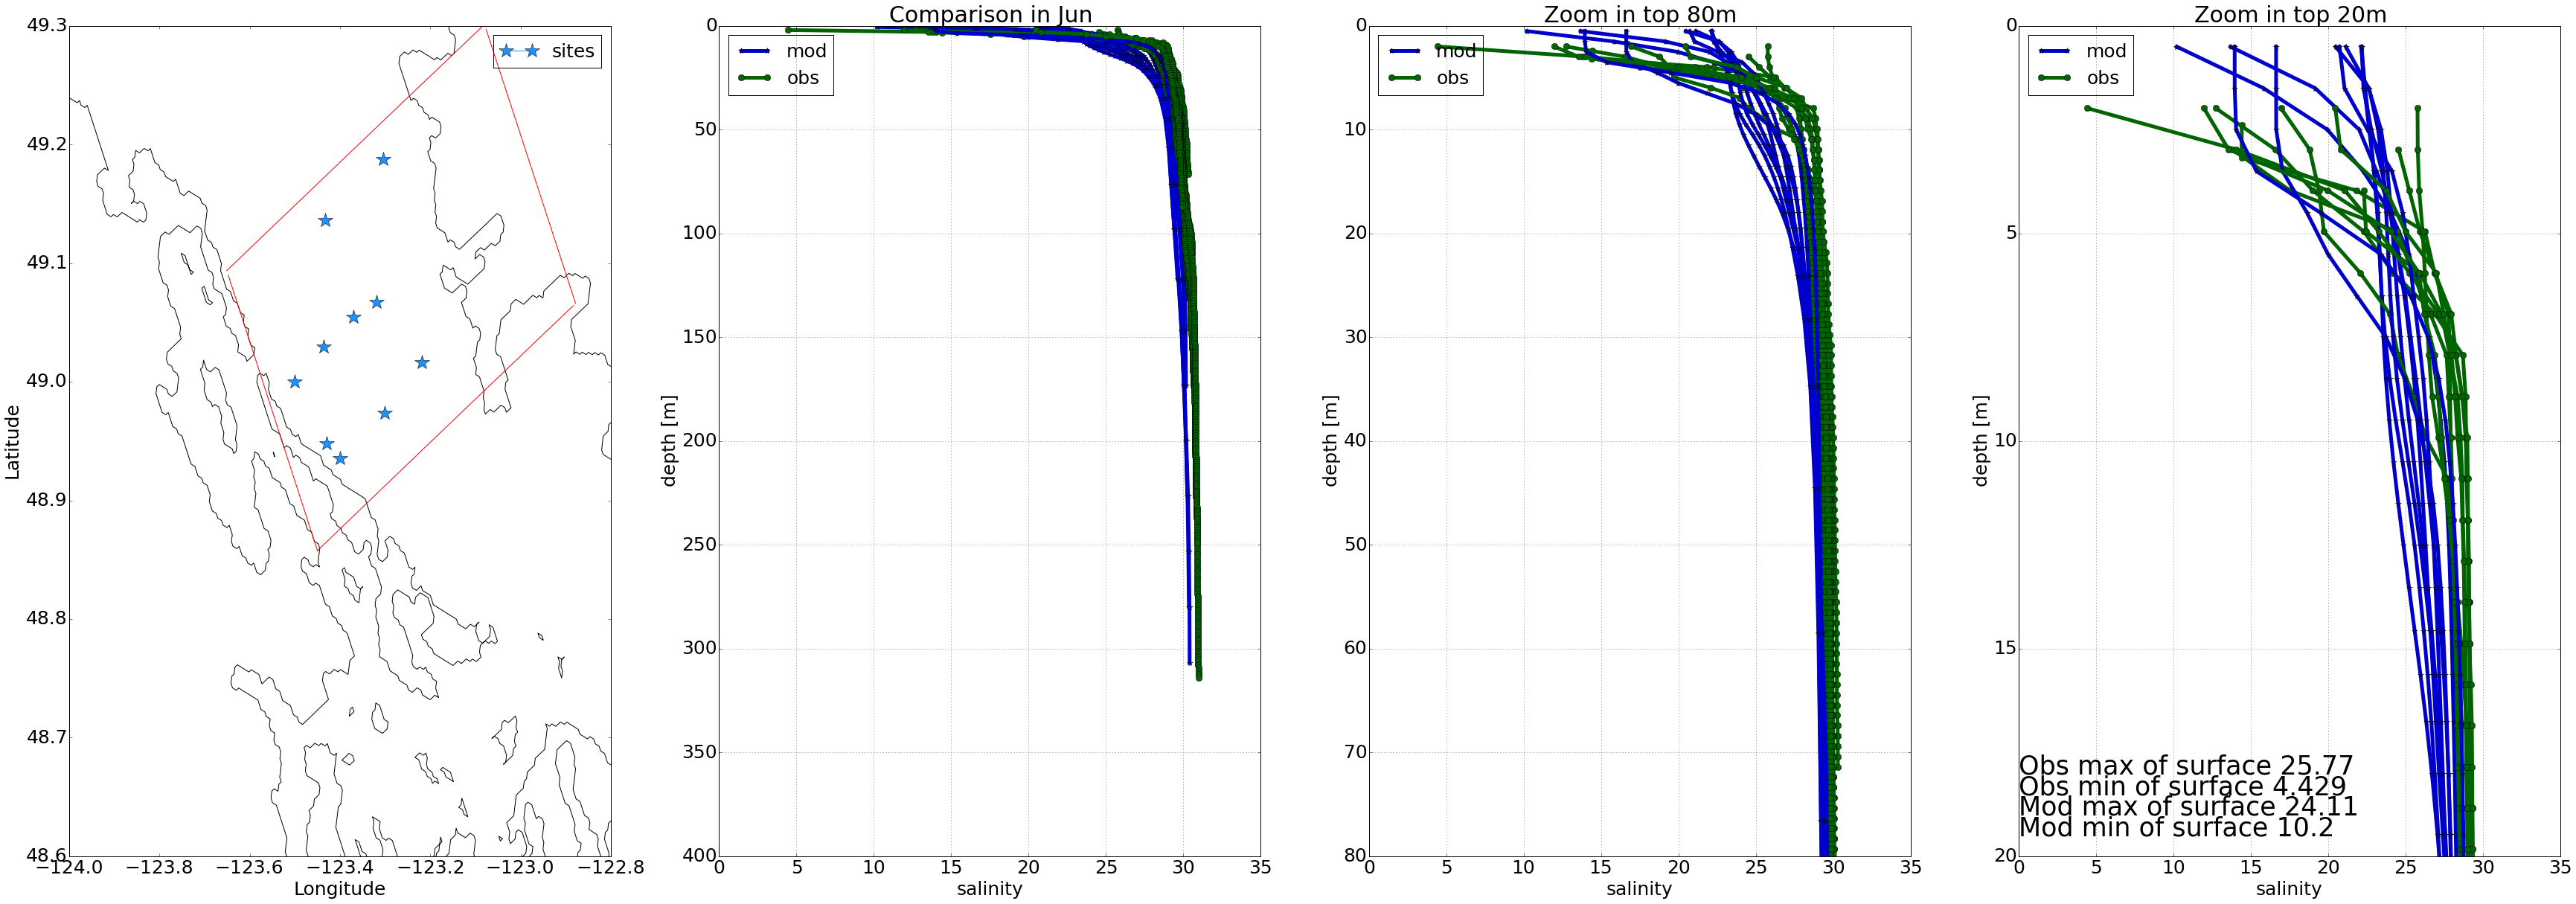

In [25]:
## June
fig = compare_cast_SoG_zoomin_more(sog, 6, 240, 350, 390, 450, '6')